trajectory forecasting with adaptive updating 

**Main Features**
- Brent Crude, WTI Crude, Dutch TTF Gas, Henry Hub Gas
- Equinor (EQNR.OL): Open, Close, High, Low, Volume, Market Cap
- OSEBX Index: Open, Close, High, Low, Volume
- VIX (volatility index)
- Dollar Index (DXY)

**Relevant Stocks**
- **Norway**: Aker BP (AKRBP), DNO (DNO), Vår Energi (VAR), Petroleum Geo-Services (PGS), BW Offshore (BWO), Frontline (FRO)
- **US/Global**: Exxon (XOM), Chevron (CVX), Shell (SHEL), BP (BP), TotalEnergies (TTE), ConocoPhillips (COP), Occidental (OXY)

**Stock Exchanges**
- S&P 500, NASDAQ, Dow Jones
- FTSE 100, DAX, CAC 40
- Nikkei 225, Hang Seng

**Commodity Prices**
- Gold (XAU), Silver (XAG)
- **Currencies**: USD/NOK, EUR/NOK, GBP/NOK, SEK/NOK, USD/EUR
- Coal (API2), Uranium (UX)
- Carbon Credits (EU ETS)

**Economic Indicators**
- **Interest Rates**: Norway (Norges Bank), US Fed Funds, ECB, BoE, BoJ, PBoC
- **Inflation**: Norway CPI, US CPI, EU HICP
- **Unemployment**: Norway, US, EU rates
- **Analyst Targets**: Equinor consensus price targets, EPS estimates


#### Fetch Dependencies

In [13]:
# Data fetching
import yfinance as yf

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#### Collect Data

In [16]:
# CELL 1: COLLECT DATA

def collect_data(start_date="2021-01-01", end_date=None):
    """Collect stock data and return as DataFrame"""
    end_date = end_date or datetime.now().strftime('%Y-%m-%d')
    
    # Updated tickers based on research
    tickers = {
        # Main stock
        'EQNR.OL': 'equinor',
       
        # Energy commodities
        'BZ=F': 'brent_crude',
        'CL=F': 'wti_crude',
        'TTF=F': 'ttf_gas',
        'NG=F': 'henry_hub',
       
        # Norwegian energy stocks
        'AKRBP.OL': 'aker_bp',
        'DNO.OL': 'dno',
        'VAR.OL': 'var_energi',
        'PGS.OL': 'pgs',
        'BWO.OL': 'bw_offshore',
        'FRO.OL': 'frontline',
       
        # Global energy stocks
        'XOM': 'exxon',
        'CVX': 'chevron',
        'SHEL': 'shell',
        'BP': 'bp',
        'TTE': 'totalenergies',
        'COP': 'conocophillips',
        'OXY': 'occidental',
       
        # Indices
        'OSEBX.OL': 'osebx',
        '^GSPC': 'sp500',
        '^IXIC': 'nasdaq',
        '^DJI': 'dow_jones',
        '^FTSE': 'ftse100',
        '^GDAXI': 'dax',
        '^FCHI': 'cac40',
        '^N225': 'nikkei',
        '^HSI': 'hang_seng',
       
        # Volatility and Dollar
        '^VIX': 'vix',
        'DX-Y.NYB': 'dollar_index',
       
        # Commodities
        'GC=F': 'gold',
        'SI=F': 'silver',
       
        # Currencies
        'NOK=X': 'usd_nok',
        'EURNOK=X': 'eur_nok',
        'GBPNOK=X': 'gbp_nok',
        'SEKNOK=X': 'sek_nok',
        'EURUSD=X': 'eur_usd'
    }
    
    all_data = {}
    
    # Download each ticker separately to avoid alignment issues
    for ticker, name in tickers.items():
        try:
            print(f"Downloading {name}...")
            # Download individually
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(data) > 0:
                # Only keep OHLC and Volume columns
                cols_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
                data = data[[c for c in cols_to_keep if c in data.columns]]
                # Handle column renaming - columns might be strings or tuples
                new_cols = []
                for col in data.columns:
                    if isinstance(col, tuple):
                        col_name = col[0] if len(col) > 0 else str(col)
                    else:
                        col_name = str(col)
                    new_cols.append(f"{name}_{col_name.lower()}")
                data.columns = new_cols
                all_data[name] = data
                print(f"  ✓ {name}: {len(data)} rows")
            else:
                print(f"  ✗ No data received for {ticker}")
                
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
    
    if not all_data:
        print("No data collected")
        return pd.DataFrame()
    
    # Combine using outer join to keep all dates
    df = pd.concat(all_data.values(), axis=1, join='outer')
    print(f"Combined data: {len(df)} rows, {len(df.columns)} columns")
    
    # Check initial NaN percentage
    nan_pct = df.isnull().sum().sum() / df.size * 100
    print(f"Initial NaN percentage: {nan_pct:.2f}%")
    
    # Keep only dates where Equinor traded (removes weekends/holidays)
    if 'equinor_close' in df.columns:
        before_filter = len(df)
        df = df[df['equinor_close'].notna()]
        print(f"Filtered to Equinor trading days: {before_filter} → {len(df)} rows")
    
    # Forward fill then backward fill to handle gaps
    df = df.ffill().bfill()
    
    # For any remaining NaNs at the beginning, drop those rows
    # This happens when some tickers start trading later than others
    first_valid_idx = df.first_valid_index()
    last_valid_idx = df.last_valid_index()
    if first_valid_idx and last_valid_idx:
        df = df.loc[first_valid_idx:last_valid_idx]
    
    # Final check for NaN percentage
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        nan_pct_final = nan_count / df.size * 100
        print(f"Warning: {nan_count} NaN values remain ({nan_pct_final:.2f}%)")
        # Show which columns have NaNs
        nan_cols = df.columns[df.isnull().any()].tolist()
        if nan_cols:
            print(f"  Columns with NaNs: {nan_cols}")
    
    print(f"\nFinal data: {len(df)} rows, {len(df.columns)} columns")
    if len(df) > 0:
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        nan_pct_final = df.isnull().sum().sum() / df.size * 100
        print(f"Final NaN percentage: {nan_pct_final:.2f}%")
    else:
        print("WARNING: No data remaining after processing")
    
    return df

In [12]:
# Run collection
data = collect_data(start_date="2015-01-01")

  ✓ equinor: 2683 rows
  ✓ brent_crude: 2686 rows
  ✓ wti_crude: 2685 rows
  ✓ ttf_gas: 1980 rows
  ✓ henry_hub: 2686 rows
  ✓ aker_bp: 2683 rows
  ✓ dno: 2683 rows
  ✓ var_energi: 893 rows
  ✓ pgs: 2400 rows
  ✓ bw_offshore: 2683 rows
  ✓ frontline: 2683 rows
  ✓ exxon: 2685 rows
  ✓ chevron: 2685 rows
  ✓ shell: 2685 rows
  ✓ bp: 2685 rows
  ✓ totalenergies: 2685 rows
  ✓ conocophillips: 2685 rows
  ✓ occidental: 2685 rows
  ✓ osebx: 2668 rows
  ✓ sp500: 2685 rows
  ✓ nasdaq: 2685 rows
  ✓ dow_jones: 2685 rows
  ✓ ftse100: 2697 rows
  ✓ dax: 2711 rows
  ✓ cac40: 2734 rows
  ✓ nikkei: 2611 rows
  ✓ hang_seng: 2628 rows
  ✓ vix: 2685 rows
  ✓ dollar_index: 2686 rows
  ✓ gold: 2684 rows
  ✓ silver: 2684 rows
  ✓ usd_nok: 2781 rows
  ✓ eur_nok: 2782 rows
  ✓ gbp_nok: 2782 rows
  ✓ sek_nok: 2781 rows
  ✓ eur_usd: 2781 rows
Combined data: 2786 rows, 180 columns
Initial NaN percentage: 5.99%
Filtered to Equinor trading days: 2786 → 2683 rows

Final data: 2683 rows, 180 columns
Date range: 2

#### Print Data

In [13]:
# CELL 2: PRINT HEAD OF DATA
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Columns: {len(data.columns)}")
print(f"Remaining NaNs: {data.isnull().sum().sum()}")
print(f"NaN percentage: {data.isnull().sum().sum() / data.size * 100:.2f}%")
data.head()

Shape: (2683, 180)
Date range: 2015-01-02 to 2025-09-05
Columns: 180
Remaining NaNs: 0
NaN percentage: 0.00%


,equinor_open,equinor_high,equinor_low,equinor_close,equinor_volume,brent_crude_open,brent_crude_high,brent_crude_low,brent_crude_close,brent_crude_volume,...,sek_nok_open,sek_nok_high,sek_nok_low,sek_nok_close,sek_nok_volume,eur_usd_open,eur_usd_high,eur_usd_low,eur_usd_close,eur_usd_volume
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,86.868472,86.999395,84.380903,85.166458,3926948.0,57.630001,58.220001,55.520000,56.419998,16707.0,...,0.94940,0.96025,0.94248,0.94682,0.0,1.208868,1.208956,1.201080,1.208941,0.0
2015-01-05,85.428317,85.952018,82.155202,82.482513,6601413.0,56.290001,56.290001,52.669998,53.110001,30065.0,...,0.95566,0.96413,0.95356,0.95520,0.0,1.195500,1.197590,1.188909,1.194643,0.0
2015-01-06,81.696961,83.660831,80.845949,83.333519,6226931.0,53.230000,53.520000,50.529999,51.099998,35494.0,...,0.96209,0.97780,0.95900,0.96274,0.0,1.193830,1.197000,1.188693,1.193902,0.0
2015-01-07,81.762422,85.100999,81.304183,84.119064,8661067.0,51.060001,51.840000,49.680000,51.150002,37082.0,...,0.97618,0.98658,0.96710,0.97493,0.0,1.187479,1.190000,1.180401,1.187536,0.0
2015-01-08,85.297376,85.886533,83.726280,84.839142,7062883.0,51.000000,51.889999,49.820000,50.959999,29469.0,...,0.96514,0.96777,0.94491,0.96572,0.0,1.183894,1.184806,1.175601,1.183600,0.0


#### Save Matrix to CSV

In [ ]:
# CELL 3: SAVE TO CSV
filepath = "data/equinor_data.csv"
data.to_csv(filepath)
print(f"Saved {len(data)} rows to {filepath}")

Saved 2683 rows to data/equinor_data.csv


### Model

EQUINOR LSTM MODEL TRAINING
Target: 15-day forward returns

1. Loading and preparing data...
   Features: 17
   Samples: 2649
   Train: 2119, Val: 265, Test: 265

2. Creating sequences (30-day lookback)...
   Train sequences: 2089
   Val sequences: 235
   Test sequences: 235

3. Training LSTM model...
Epoch 0: Train Loss 0.004807, Val Loss 0.004826
Epoch 20: Train Loss 0.000889, Val Loss 0.004371
Epoch 40: Train Loss 0.000595, Val Loss 0.005342
Epoch 60: Train Loss 0.000533, Val Loss 0.005375
Epoch 80: Train Loss 0.000515, Val Loss 0.005555

4. Evaluating on test set...

Test Set Performance:
MSE: 0.007760
MAE: 0.072638
R²: -0.9416
Direction Accuracy: 52.77%

5. Plotting results...


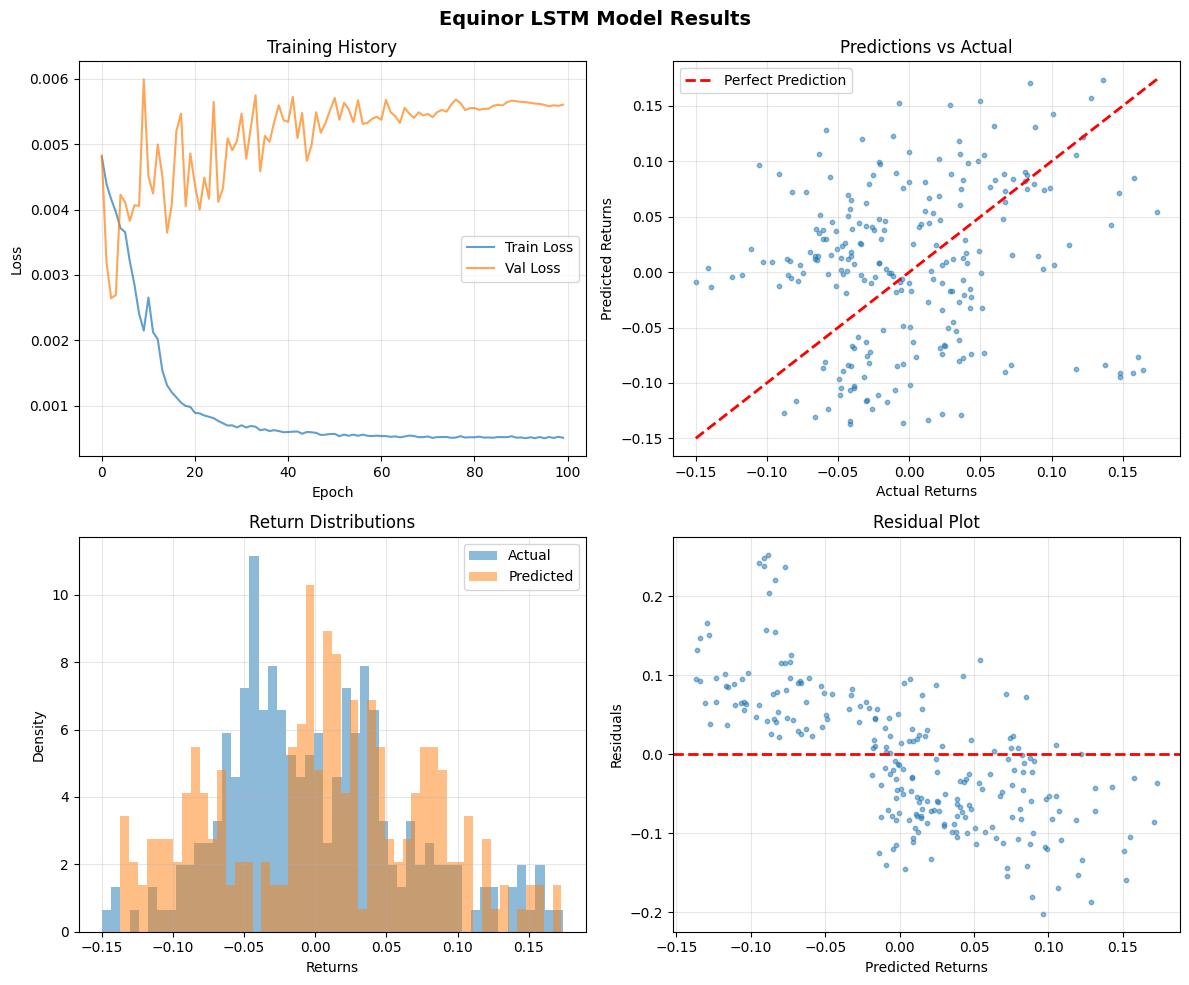


 Training complete!
 Model and scaler saved for future predictions


In [14]:
"""
Equinor LSTM Model - Focused Implementation
Following the specified architecture for 15-day forward returns
"""

# Load and prepare data
def prepare_data(filepath='data/equinor_data_8sept.csv'):
    """Load data and create features as specified"""
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    
    # Step 1: Create target variable (15-day forward returns)
    data['target'] = data['equinor_close'].pct_change(15).shift(-15)
    
    # Step 2: Feature engineering (as specified in plan)
    # Add returns
    for asset in ['equinor', 'brent_crude', 'wti_crude', 'usd_nok']:
        if f'{asset}_close' in data.columns:
            data[f'{asset}_return_1d'] = data[f'{asset}_close'].pct_change(1)
            data[f'{asset}_return_5d'] = data[f'{asset}_close'].pct_change(5)
    
    # Add moving averages
    for asset in ['equinor', 'brent_crude']:
        if f'{asset}_close' in data.columns:
            data[f'{asset}_ma5'] = data[f'{asset}_close'].rolling(5).mean()
            data[f'{asset}_ma20'] = data[f'{asset}_close'].rolling(20).mean()
    
    # Select core features
    features = ['equinor_close', 'brent_crude_close', 'wti_crude_close', 
                'usd_nok_close', 'vix_close'] + \
               [col for col in data.columns if 'return_' in col or '_ma' in col]
    
    # Filter to available features
    features = [f for f in features if f in data.columns]
    
    X = data[features].fillna(method='ffill')
    y = data['target']
    
    # Remove NaN values
    valid_idx = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_idx]
    y = y[valid_idx]
    
    return X, y

# Step 4: Create LSTM sequences
def create_sequences(X, y, seq_length=30):
    """Create sequences for LSTM training"""
    sequences, targets = [], []
    for i in range(seq_length, len(X)):
        sequences.append(X.iloc[i-seq_length:i].values)
        targets.append(y.iloc[i])
    return np.array(sequences), np.array(targets)

# Step 5: LSTM Model
class EquinorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

# PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Training function
def train_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, 
                input_size, epochs=100, batch_size=32, lr=0.001):
    """Train LSTM model"""
    
    # Create datasets
    train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
    val_dataset = TimeSeriesDataset(X_val_seq, y_val_seq)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model
    model = EquinorLSTM(input_size=input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    # Step 6: Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Train Loss {avg_train_loss:.6f}, Val Loss {avg_val_loss:.6f}')
    
    return model, train_losses, val_losses

# Evaluation function
def evaluate_model(model, X_test_seq, y_test_seq):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_seq)
        predictions = model(X_test_tensor).squeeze().numpy()
    
    # Calculate metrics
    mse = np.mean((predictions - y_test_seq) ** 2)
    mae = np.mean(np.abs(predictions - y_test_seq))
    
    # Directional accuracy
    direction_correct = np.mean((predictions > 0) == (y_test_seq > 0))
    
    # R-squared
    ss_res = np.sum((y_test_seq - predictions) ** 2)
    ss_tot = np.sum((y_test_seq - np.mean(y_test_seq)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"\nTest Set Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.4f}")
    print(f"Direction Accuracy: {direction_correct:.2%}")
    
    return predictions, {'mse': mse, 'mae': mae, 'r2': r2, 'direction_acc': direction_correct}

# Plotting function
def plot_results(y_true, y_pred, train_losses, val_losses):
    """Visualize results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training history
    axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Val Loss', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Predictions vs Actual
    axes[0, 1].scatter(y_true, y_pred, alpha=0.5, s=10)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                    'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Returns')
    axes[0, 1].set_ylabel('Predicted Returns')
    axes[0, 1].set_title('Predictions vs Actual')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Return distributions
    axes[1, 0].hist(y_true, bins=50, alpha=0.5, label='Actual', density=True)
    axes[1, 0].hist(y_pred, bins=50, alpha=0.5, label='Predicted', density=True)
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Return Distributions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[1, 1].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Predicted Returns')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].set_title('Residual Plot')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Equinor LSTM Model Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    print("=" * 60)
    print("EQUINOR LSTM MODEL TRAINING")
    print("Target: 15-day forward returns")
    print("=" * 60)
    
    # Load and prepare data
    print("\n1. Loading and preparing data...")
    X, y = prepare_data('data/equinor_data_8sept.csv')
    print(f"   Features: {len(X.columns)}")
    print(f"   Samples: {len(X)}")
    
    # Step 3: Train/Validation/Test Split
    split_idx = int(0.8 * len(X))
    val_split_idx = int(0.9 * len(X))
    
    X_train = X[:split_idx]
    y_train = y[:split_idx]
    X_val = X[split_idx:val_split_idx]
    y_val = y[split_idx:val_split_idx]
    X_test = X[val_split_idx:]
    y_test = y[val_split_idx:]
    
    print(f"   Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Create sequences
    print("\n2. Creating sequences (30-day lookback)...")
    X_train_seq, y_train_seq = create_sequences(
        pd.DataFrame(X_train_scaled, columns=X.columns), 
        pd.Series(y_train.values)
    )
    X_val_seq, y_val_seq = create_sequences(
        pd.DataFrame(X_val_scaled, columns=X.columns),
        pd.Series(y_val.values)
    )
    X_test_seq, y_test_seq = create_sequences(
        pd.DataFrame(X_test_scaled, columns=X.columns),
        pd.Series(y_test.values)
    )
    
    print(f"   Train sequences: {len(X_train_seq)}")
    print(f"   Val sequences: {len(X_val_seq)}")
    print(f"   Test sequences: {len(X_test_seq)}")
    
    # Train model
    print("\n3. Training LSTM model...")
    model, train_losses, val_losses = train_model(
        X_train_seq, y_train_seq, 
        X_val_seq, y_val_seq,
        input_size=X.shape[1],
        epochs=100,
        batch_size=32,
        lr=0.001
    )
    
    # Evaluate
    print("\n4. Evaluating on test set...")
    predictions, metrics = evaluate_model(model, X_test_seq, y_test_seq)
    
    # Plot results
    print("\n5. Plotting results...")
    plot_results(y_test_seq, predictions, train_losses, val_losses)
    
    return model, scaler, metrics

if __name__ == "__main__":
    model, scaler, metrics = main()
    print("\n Training complete!")
    print(" Model and scaler saved for future predictions")